In [5]:
import pandas as pd
import re
from datetime import date
import numpy as np
import math
from nltk import everygrams
import nltk
from nltk.corpus import stopwords
from textblob import TextBlob
from nltk.stem.snowball import SnowballStemmer

from sklearn import feature_extraction
from sklearn.feature_extraction.text import TfidfVectorizer

In [94]:
import nltk
import ssl

try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context

nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package wordnet to /Users/admin/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/admin/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/admin/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [6]:
df = pd.read_csv('internshala_clean.csv')

### Perks

In [154]:
all_perks = {}

def extract_perks(series):
    if(type(series) == str):
        perks = series.split("\n")
        for perk in perks:
            perk = perk.strip()
            all_perks[perk] = all_perks.get(perk, 0) + 1

df.perks.apply(extract_perks)

0       None
1       None
2       None
3       None
4       None
        ... 
2369    None
2370    None
2371    None
2372    None
2373    None
Name: perks, Length: 2374, dtype: object

In [160]:
perks_series = pd.Series(data=list(all_perks.values()), index=list(all_perks.keys()))

In [161]:
perks_series.index

Index(['Certificate', 'Flexible work hours', '5 days a week',
       'Letter of recommendation', 'Informal dress code',
       'Free snacks & beverages', 'Job offer'],
      dtype='object')

In [162]:
fig = go.Figure(data=[go.Pie(labels=perks_series.index, values=perks_series.values, textinfo='label+percent',
                             insidetextorientation='radial'
                            )])
fig.show()

### Who Can Apply feature

In [20]:
all_application_features = {}

def extract_perks(series):
    if(type(series) == str):
        application_data = series.split("\n")
        for application in application_data:
            application = application.strip()
            all_application_features[application] = all_application_features.get(application, 0) + 1

df.who_can_apply.apply(extract_perks)

0       None
1       None
2       None
3       None
4       None
        ... 
2369    None
2370    None
2371    None
2372    None
2373    None
Name: who_can_apply, Length: 2374, dtype: object

In [21]:
all_application_features

{'Only those candidates can apply who:': 2374,
 '1. are available for the work from home job/internship': 1715,
 "2. can start the work from home job/internship between 19th May'21 and 23rd Jun'21": 144,
 '3. are available for duration of 5 months': 24,
 '4. have relevant skills and interests': 2123,
 '* Women wanting to start/restart their career can also apply.': 1324,
 "2. can start the work from home job/internship between 26th May'21 and 30th Jun'21": 174,
 '3. are available for duration of 4 months': 126,
 "2. can start the work from home job/internship between 23rd May'21 and 27th Jun'21": 54,
 '3. are available for duration of 1 month': 179,
 '1. are available for full time (in-office) internship': 599,
 "2. can start the internship between 23rd May'21 and 27th Jun'21": 11,
 '3. are available for duration of 6 months': 826,
 "2. can start the work from home job/internship between 25th May'21 and 29th Jun'21": 97,
 "2. can start the work from home job/internship between 28th May

## Text Analysis

In [7]:
new_df = df.rename(columns={'about_the_work_from_home_job/internship':'about_internship'})
text_analysis_df = new_df[['about_internship', 'other_requirements']]
text_analysis_df.fillna('', inplace=True)

/Users/admin/Projects/Msc/Data Mining/mining-env/lib/python3.9/site-packages/pandas/core/frame.py:4462: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(


In [8]:
text_analysis_df

,about_internship,other_requirements
0,Selected intern's day-to-day responsibilities ...,1. Experience in hands-on development and trou...
1,Selected intern's day-to-day responsibilities ...,
2,Selected intern's day-to-day responsibilities ...,
3,,
4,Selected intern's day-to-day responsibilities ...,
...,...,...
2369,Selected intern's day-to-day responsibilities ...,
2370,Selected intern's day-to-day responsibilities ...,
2371,1. Working on direct client projects and handl...,
2372,,


### Text Preprocessing

In [130]:
def preprocess(dataframe, feature, function):
    dataframe.loc[:, feature] = dataframe[feature].apply(function)

In [10]:
def convert_to_lowercase(s):
    if(type(s) == str):
        return s.lower()
    else:
        return None

def remove_special_char(s):
    return s.replace('[^\w\s]','') if type(s) == str else None

def remove_stop_words(s):
    if type(s) == str:
        stop = stopwords.words('english')
        return " ".join(x for x in s.split() if x not in stop)
    else:
        return None
    
def correct_spellings(s):
    if(type(s) == str):
        return str(TextBlob(s).correct())
    else: 
        return None

stemmer = SnowballStemmer("english")
def tokenize_and_stem(text):
    '''
        Functions for sentence tokenizer, to remove numeric tokens and raw #punctuation
    '''
    if type(text) != str: return None
    tokens = [word for sent in nltk.sent_tokenize(text) for  word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    stems = [stemmer.stem(t) for t in filtered_tokens]
    return stems

preprocessing_functions = [convert_to_lowercase, remove_special_char, remove_stop_words]

for func in preprocessing_functions:
    preprocess(text_analysis_df, 'about_internship', func)

/Users/admin/Projects/Msc/Data Mining/mining-env/lib/python3.9/site-packages/pandas/core/indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


### Keyword Extraction using TF-IDF

In [115]:
tfidf_vectorizer = TfidfVectorizer(max_features=200000,stop_words='english', use_idf=True, ngram_range=(1,3))

tfidf_matrix = tfidf_vectorizer.fit_transform(text_analysis_df.about_internship)

terms = tfidf_vectorizer.get_feature_names()

In [127]:
feature_array = np.array(tfidf_vectorizer.get_feature_names())
tfidf_sorting = np.argsort(tfidf_matrix.toarray()).flatten()[::-1]

n = 3
top_n = feature_array[tfidf_sorting][:n]

In [117]:
data = np.squeeze(np.sum(tfidf_matrix.todense(), axis=0).reshape(-1,1)).tolist()[0]

In [118]:
keyword_series = pd.Series(data=data, index=tfidf_vectorizer.get_feature_names())

In [120]:
keyword_series = keyword_series.sort_values(ascending=False)

In [125]:
keyword_series[30: 50]

new                              19.093998
develop                          17.120192
software                         16.124382
user                             15.409647
react                            15.270170
include work                     15.121716
mobile                           15.089814
responsibilities include work    15.075362
features                         14.734603
android                          14.611351
data                             14.470755
designing                        14.384072
creating                         14.305479
performance                      14.225763
create                           14.196863
backend                          14.098060
js                               13.928468
testing                          13.710084
build                            13.408841
apis                             13.213017
dtype: float64

In [15]:
feature_array[tfidf_sorting][:200]

array(['web', 'web pages', 'pages', 'designs', 'languages turn photoshop',
       'files animated responsive', 'web technologies work',
       'management prototype', 'management prototype ideas',
       'wireframes visual designs', 'wireframes visual',
       'prototype ideas', 'prototype ideas order',
       'multiple browsers mobile', 'files animated',
       'web based animation', 'css web pages', 'elevate concepts level',
       'javascript scripting languages', 'css web', 'elevate concepts',
       'fellow team members', 'commerce using',
       'commerce using javascript', 'elevate', 'web pages based',
       'effective communication', 'effective communication fellow',
       'tools ensure technical', 'css3 web based', 'javascript scripting',
       'fellow team', 'members management',
       'devices thoroughly demonstrate', 'engage development',
       'engage development websites', 'concepts level',
       'development websites includes', 'scripting languages turn',
       'i

### Keyword Extraction using YAKE

In [26]:
from yake import KeywordExtractor

all_keywords = {}
kw_extractor = KeywordExtractor(lan="en")

def yake_keyword_extractor(input_str):
    keywords = kw_extractor.extract_keywords(text=input_str)
    keywords = [x for x, y in keywords]
    for keyword in keywords:
        all_keywords[keyword] = all_keywords.get(keyword, 0) + 1
    return ','.join(keywords)

text_analysis_df.about_internship.apply(yake_keyword_extractor)

0       selected intern,responsibilities include,selec...
1       selected intern,responsibilities include,selec...
2       selected intern,responsibilities include,selec...
3                                                        
4       selected intern,responsibilities include,selec...
                              ...                        
2369    selected intern,responsibilities include,selec...
2370    selected intern,responsibilities include,artif...
2371    working,experience,development,gain,working di...
2372                                                     
2373    selected intern,responsibilities include,web,i...
Name: about_internship, Length: 2374, dtype: object

In [19]:
keywords

['selected intern',
 'responsibilities include',
 'selected',
 'intern',
 'responsibilities',
 'include',
 'css practices',
 'interface',
 'creating website layout',
 'creating website',
 'modern html',
 'application',
 'codes',
 'team',
 'website layout',
 'layout using modern',
 'creating',
 'html',
 'css',
 'practices']

### Keyword word extraction using Count Vectorizer 

In [40]:
count_vec = feature_extraction.text.CountVectorizer()
response = count_vec.fit_transform(text_analysis_df.about_internship)


In [45]:
feature_array = np.array(count_vec.get_feature_names())
count_sorting = np.argsort(response.toarray()).flatten()[::-1]

feature_array[count_sorting][:100]

array(['web', 'development', 'pages', 'based', 'designs', 'day', 'using',
       'work', 'engaging', 'websites', 'animation', 'level', 'commercial',
       'effective', 'to', 'intern', 'communication', 'tools',
       'responsibilities', 'feasibility', 'ideas', 'elevate', 'scripting',
       'mobile', 'fellow', 'commerce', 'animated', 'functionality',
       'visual', 'photoshop', 'test', 'prototype', 'multiple', 'dynamic',
       'includes', 'include', 'technologies', 'thoroughly', 'technical',
       'devices', 'ux', 'team', 'source', 'next', 'css', 'css3',
       'management', 'implementation', 'responsive', 'wireframes',
       'learn', 'languages', 'html', 'engage', 'order', 'demonstrate',
       'concepts', 'selected', 'javascript', 'turn', 'works', 'browsers',
       'members', 'open', 'ensure', 'ui', 'files', 'html5', 'es5',
       'everything', 'evse', 'evolving', 'enhancement', 'enhancements',
       'enhancing', 'error', 'evolve', 'evolution', 'everyday', 'erp',
       'enor

In [56]:
count_vect_df = pd.DataFrame(response.todense(), columns=count_vec.get_feature_names())

In [39]:
keywords_series = pd.Series(all_keywords)

keywords_series.sort_values(ascending=False)[:160]

selected intern             1654
responsibilities include    1646
selected                    1632
intern                      1621
responsibilities            1611
                            ... 
design build                  18
designing building            18
bugs                          18
products                      18
technical                     18
Length: 160, dtype: int64

In [89]:
data = np.squeeze(np.sum(response.todense(), axis=0).reshape(-1,1)).tolist()[0]

In [60]:
count_vect_df['11'].sum()

32

In [91]:
keyword_series = pd.Series(data=data, index=count_vec.get_feature_names())

In [93]:
keyword_series = keyword_series.sort_values(ascending=False)

In [126]:
keyword_series[:40]

day                                 87.135030
working                             44.943190
day day                             43.392380
intern                              43.262979
include                             43.068278
selected                            42.988183
selected intern                     42.896717
responsibilities                    42.871539
intern day                          42.859560
intern day day                      42.859560
selected intern day                 42.859288
day responsibilities                42.840408
day day responsibilities            42.840408
responsibilities include            42.819319
day responsibilities include        42.801609
work                                41.842245
development                         31.706766
website                             28.948596
web                                 26.869604
end                                 25.845426
using                               24.893811
design                            

#### Word Cloud

In [149]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

def get_word_cloud(input_str):
    wordcloud = WordCloud().generate(input_str)
    plt.figure(figsize=(10,5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")

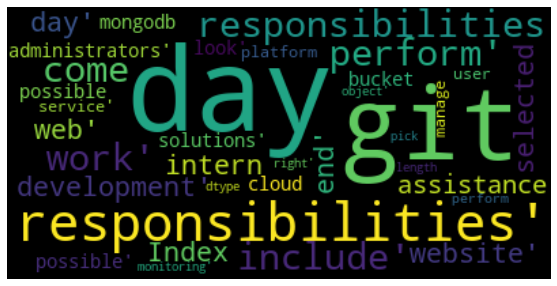

In [150]:
get_word_cloud(str(keyword_series[10:].index))